In [3]:
# Set to True if running notebook on AWS/EMR
EMR=False 

## Computing PCA using RDDs

##  PCA

The vectors that we want to analyze have length, or dimension, of 365, corresponding to the number of 
days in a year.

We will perform [Principle component analysis (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis)
on these vectors. There are two steps to this process:

1) Computing the covariance matrix: this is a  simple computation. However, it takes a long time to compute and it benefits from using an RDD because it involves all of the input vectors.

2) Computing the eigenvector decomposition. this is a more complex computation, but it takes a fraction of a second because the size to the covariance matrix is $365 \times 365$, which is quite small. We do it on the head node usin `linalg`

### Computing the covariance matrix
Suppose that the data vectors are the column vectors denoted $x$ then the covariance matrix is defined to be
$$
E(x x^T)-E(x)E(x)^T
$$

Where $x x^T$ is the **outer product** of $x$ with itself.

If the data that we have is $x_1,x_2,x_n$ then  we estimate the covariance matrix:
$$
\hat{E}(x x^T)-\hat{E}(x)\hat{E}(x)^T
$$

the estimates we use are:
$$
\hat{E}(x x^T) = \frac{1}{n} \sum_{i=1}^n x_i x_i^T,\;\;\;\;\;
\hat{E}(x) = \frac{1}{n} \sum_{i=1}^n x_i
$$

## Computing the covariance matrix where the `nan`s are
### The effect of  `nan`s in arithmetic operations
* We use an RDD of numpy arrays, instead of Dataframes.
* Why? Because unlike dataframes, `numpy.nanmean` treats `nan` entries correctly.

### Calculating the mean of a vector with nan's
* We often get vectors $x$ in which some, but not all, of the entries are `nan`. 
* We want to compute the mean of the elements of $x$. 
* If we use `np.mean` we will get the result `nan`. 
* A useful alternative is to use `np.nanmean` which removes the `nan` elements and takes the mean of the rest.

In [2]:
import numpy as np
a=np.array([1,np.nan,2,np.nan,3,4,5])
print('a=',a)
print('np.mean(a)=',np.mean(a))
print('np.mean(np.nan_to_num(a))=',np.mean(np.nan_to_num(a))) # =(1+0+2+0+3+4+5)/7
print('np.nanmean(a)=',np.nanmean(a)) # =(1+2+3+4+5)/5

a= [ 1. nan  2. nan  3.  4.  5.]
np.mean(a)= nan
np.mean(np.nan_to_num(a))= 2.142857142857143
np.nanmean(a)= 3.0


### The outer poduct of a vector with `nan`s with itself

In [3]:
np.outer(a,a)

array([[ 1., nan,  2., nan,  3.,  4.,  5.],
       [nan, nan, nan, nan, nan, nan, nan],
       [ 2., nan,  4., nan,  6.,  8., 10.],
       [nan, nan, nan, nan, nan, nan, nan],
       [ 3., nan,  6., nan,  9., 12., 15.],
       [ 4., nan,  8., nan, 12., 16., 20.],
       [ 5., nan, 10., nan, 15., 20., 25.]])

### When should you not use `np.nanmean` ?
Using `n.nanmean` is equivalent to assuming that choice of which elements to remove is independent of the values of the elements. 
* Example of bad case: suppose the larger elements have a higher probability of being `nan`. In that case `np.nanmean` will under-estimate the mean

### Computing the covariance  when there are `nan`s
The covariance is a mean of outer products.

We calculate two matrices:
* $S$ - the sum of the matrices, whereh `nan`->0
* $N$ - the number of not-`nan` element for each matrix location.

We then calculate the mean as $S/N$ (division is done element-wise)

## Computing the mean together with the covariance
To compute the covariance matrix we need to compute both $\hat{E}(x x^T)$ and $\hat{E}(x)$. Using a simple trick, we can compute both at the same time.

Here is the trick: lets denote a $d$ dimensional **column vector** by $\vec{x} = (x_1,x_2,\ldots,x_d)$ (note that the subscript here is the index of the coordinate, not the index of the example in the training set as used above). 

The augmented vector $\vec{x}'$ is defined to be the $d+1$ dimensional vector $\vec{x}' = (1,x_1,x_2,\ldots,x_d)$.

The outer product of $\vec{x}'$ with itself is equal to 

$$ \vec{x}' {\vec{x}'}^T
= \left[\begin{array}{c|ccc}
    1 &  &{\vec{x}}^T &\\
    \hline \\
    \vec{x} & &\vec{x} {\vec{x}}^T \\ \\
    \end{array}
    \right]
$$

Where the lower left matrix is the original outer product $\vec{x} {\vec{x}}^T$ and the first row and the first column are $\vec{x}^T$ and $\vec{x}$ respectively.

Now suppose that we do the take the average of the outer product of the augmented vector and convince yourself that:
$$
\hat{E}(\vec{x}' {\vec{x}'}^T) = \frac{1}{n} \sum_{i=1}^n {\vec{x}'}_i {\vec{x}'}_i^T
= \left[\begin{array}{c|ccc}
    1 &  &\hat{E}(\vec{x})^T &\\
    \hline \\
    \hat{E}(\vec{x}) & &\hat{E}(\vec{x} {\vec{x}}^T) \\ \\
    \end{array}
    \right]
$$

So indeed, we have produced the outer product average together with (two copies of) the average $\hat{E}(\vec{x})$

In [4]:
if not EMR:
    import findspark
    findspark.init()
from pyspark import SparkContext,SparkConf

def create_sc(pyFiles):
    sc_conf = SparkConf()
    sc_conf.setAppName("Weather_PCA")
    sc_conf.set('spark.executor.memory', '3g')
    sc_conf.set('spark.executor.cores', '1')
    sc_conf.set('spark.cores.max', '4')
    sc_conf.set('spark.default.parallelism','10')
    sc_conf.set('spark.logConf', True)
    print(sc_conf.getAll())

    sc = SparkContext(conf=sc_conf,pyFiles=pyFiles)

    return sc 

sc = create_sc(pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStatistics.py'])

dict_items([('spark.app.name', 'Weather_PCA'), ('spark.executor.memory', '3g'), ('spark.executor.cores', '1'), ('spark.cores.max', '4'), ('spark.default.parallelism', '10'), ('spark.logConf', 'True')])


In [5]:
from pyspark.sql import *
sqlContext = SQLContext(sc)

import numpy as np
from lib.computeStatistics import *

### Climate data

The data we will use here comes from [NOAA](https://www.ncdc.noaa.gov/). Specifically, it was downloaded from This [FTP site](ftp://ftp.ncdc.noaa.gov/pub/data/ghcn/daily/).

There is a large variety of measurements from all over the world, from 1870 will 2012.
in the directory `../../Data/Weather` you will find the following useful files:

* data-source.txt: the source of the data
* ghcnd-readme.txt: A description of the content and format of the data
* ghcnd-stations.txt: A table describing the Meteorological stations.



### Data cleaning

* Most measurements exists only for a tiny fraction of the stations and years. We therefor restrict our use to the following measurements:
```python
['TMAX', 'SNOW', 'SNWD', 'TMIN', 'PRCP', 'TOBS']
```

* 8 We consider only measurement-years that have at most 50 `NaN` entries

* We consider only measurements in the continential USA

* We partition the stations into the states of the continental USA (plus a few stations from states in canada and mexico).

In [8]:
!ls ../../../Data/Weather

NY.parquet               Weather_Stations.parquet recon_NY_SNWD.parquet
NY.tgz                   Weather_stations.tgz     stations.parquet
STAT_NY.pickle           decomp_NY_SNWD.parquet
WeatherSTAT_NY.pickle    decon_NY_SNWD.parquet


In [19]:
state='NY'
if not EMR:
    data_dir='../../../Data/Weather'
    tarname=state+'.tgz'
    parquet=state+'.parquet'

    !rm -rf $data_dir/$tarname

    command="curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/%s > %s/%s"%(tarname,data_dir,tarname)
    print(command)
    !$command
    !ls -lh $data_dir/$tarname

    cur_dir,=!pwd
    %cd $data_dir
    !rm -rf ./$parquet
    !tar -xzf $tarname
    !ls -l ./$parquet
    !du ./$parquet
    %cd $cur_dir

curl https://mas-dse-open.s3.amazonaws.com/Weather/by_state/NY.tgz > ../../../Data/Weather/NY.tgz
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 63.2M  100 63.2M    0     0  18.1M      0  0:00:03  0:00:03 --:--:-- 18.1M
-rw-r--r--  1 yoavfreund  staff    63M Apr 25 18:59 ../../../Data/Weather/NY.tgz
/Users/yoavfreund/projects/edX-Micro-Master-in-Data-Science/big-data-analytics-using-spark/notebooks/Data/Weather
total 155648
-rw-r--r--  1 yoavfreund  staff        0 Apr 18 18:12 _SUCCESS
-rw-r--r--  1 yoavfreund  staff  3660544 Apr 18 18:12 part-00000-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
-rw-r--r--  1 yoavfreund  staff  4138689 Apr 18 18:12 part-00001-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
-rw-r--r--  1 yoavfreund  staff  3946287 Apr 18 18:12 part-00002-89caf7c0-9733-40ec-a650-7f368529dd01-c000.snappy.parquet
-rw-r--r--  1 yoavfreund  st

In [10]:
if EMR:  # not debugged, should use complete parquet and extract just the state of interest.
    data_dir='/mnt/workspace/Data'
    !hdfs dfs -mkdir /weather/
    !hdfs dfs -CopyFromLocal $data_dir/$parquet /weather/$parquet

    # When running on cluster
    #!mv ../../Data/Weather/NY.parquet /mnt/workspace/Data/NY.parquet

    !aws s3 cp --recursive --quiet /mnt/workspace/Data/NY.parquet s3://dse-weather/NY.parquet

    !aws s3 ls s3://dse-weather/

    local_path=data_dir+'/'+parquet
    hdfs_path='/weather/'+parquet
    local_path,hdfs_path

    !hdfs dfs -copyFromLocal $local_path $hdfs_path

    !hdfs dfs -du /weather/
    parquet_path=hdfs_path

In [20]:
parquet_path = data_dir+'/'+parquet
!du -sh $parquet_path

 76M	../../../Data/Weather/NY.parquet


In [21]:
%%time
df=sqlContext.read.parquet(parquet_path)
print(df.count())

168398
CPU times: user 1.9 ms, sys: 2.23 ms, total: 4.13 ms
Wall time: 188 ms


In [23]:
df.show(2)

+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|    Station|Measurement|Year|              Values|       dist_coast|      latitude|         longitude|        elevation|state|             name|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
|USW00094704|   PRCP_s20|1945|[00 00 00 00 00 0...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
|USW00094704|   PRCP_s20|1946|[99 46 52 46 0B 4...|361.8320007324219|42.57080078125|-77.71330261230469|208.8000030517578|   NY|DANSVILLE MUNI AP|
+-----------+-----------+----+--------------------+-----------------+--------------+------------------+-----------------+-----+-----------------+
only showing top 2 rows



In [24]:
sqlContext.registerDataFrameAsTable(df,'table')

In [25]:
Query="""
SELECT Measurement,count(Measurement) as count 
FROM table 
GROUP BY Measurement
ORDER BY Measurement
"""
counts=sqlContext.sql(Query).toPandas()
measurements=list(counts['Measurement'])

In [26]:
counts

,Measurement,count
0,PRCP,16118
1,PRCP_s20,16118
2,SNOW,15629
3,SNOW_s20,15629
4,SNWD,14617
5,SNWD_s20,14617
6,TMAX,13437
7,TMAX_s20,13437
8,TMIN,13442
9,TMIN_s20,13442


In [27]:
%pylab inline
def plot_row(rows):
    figure(figsize=[10,7])
    for row in rows:
        plot(unpackArray(row['Values'],np.float16),
             label="%s/%s/%d"%(row['Measurement'],row['name'],row['Year']))
    legend()

Populating the interactive namespace from numpy and matplotlib


/Users/yoavfreund/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['time']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


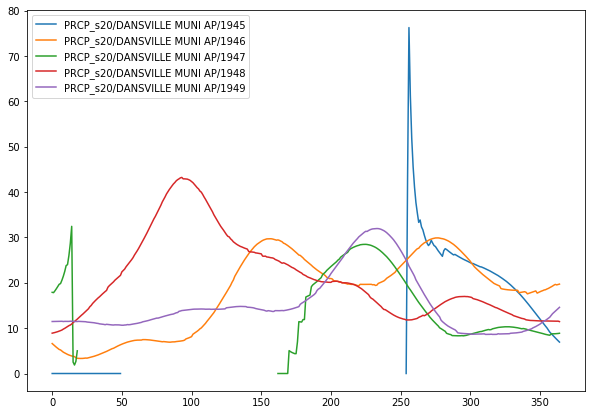

In [28]:
rows=df.rdd.take(5)
plot_row(rows)


SELECT * 
FROM table 
WHERE name='DANSVILLE MUNI AP' AND Year=1948 AND (Measurement='PRCP' OR Measurement='PRCP_s20')



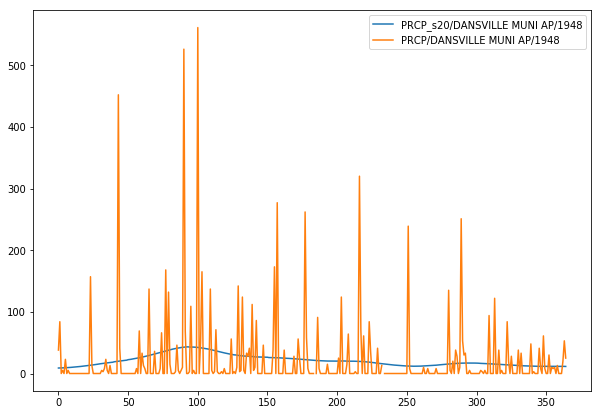

In [29]:
name='DANSVILLE MUNI AP'
Year=1948

Query="""
SELECT * 
FROM table 
WHERE name='%s' AND Year=%d AND (Measurement='PRCP' OR Measurement='PRCP_s20')
"""%(name,Year)
print(Query)
Rows=sqlContext.sql(Query)
plot_row(Rows.rdd.collect())

In [30]:
from time import time
t=time()

N=sc.defaultParallelism
print('Number of executors=',N)
print('took',time()-t,'seconds')

Number of executors= 10
took 0.00115203857421875 seconds


In [41]:
# %load lib/computeStatistics.py


from numpy import linalg as LA
import numpy as np

from numpy_pack import packArray,unpackArray
from spark_PCA import computeCov
from time import time

def computeStatistics(sqlContext,df):
    """Compute all of the statistics for a given dataframe
    Input: sqlContext: to perform SQL queries
            df: dataframe with the fields 
            Station(string), Measurement(string), Year(integer), Values (byteArray with 365 float16 numbers)
    returns: STAT, a dictionary of dictionaries. First key is measurement, 
             second keys described in computeStats.STAT_Descriptions
    """

    sqlContext.registerDataFrameAsTable(df,'weather')
    STAT={}  # dictionary storing the statistics for each measurement
    Query="""
    SELECT Measurement,count(Measurement) as count 
    FROM weather
    GROUP BY Measurement
    ORDER BY count
    """
    counts=sqlContext.sql(Query).toPandas()
    measurements=list(counts['Measurement'])
    
    for meas in measurements:
        t=time()
        Query="SELECT * FROM weather\n\tWHERE measurement = '%s'"%(meas)
        print(Query)
        mdf = sqlContext.sql(Query)
        print(meas,': shape of mdf is ',mdf.count())

        data=mdf.rdd.map(lambda row: unpackArray(row['Values'],np.float16))
        #print('data.count=',data.count())
        #print('data.first=',data.first())
        #Compute basic statistics
        STAT[meas]=computeOverAllDist(data)   # Compute the statistics 

        # compute covariance matrix
        OUT=computeCov(data)

        #find PCA decomposition
        eigval,eigvec=LA.eig(OUT['Cov'])

        # collect all of the statistics in STAT[meas]
        STAT[meas]['eigval']=eigval
        STAT[meas]['eigvec']=eigvec
        STAT[meas].update(OUT)

        print('time for',meas,'is',time()-t)
    
    return STAT

# Compute the overall distribution of values and the distribution of the number of nan per year
def find_percentiles(SortedVals,percentile):
    L=int(len(SortedVals)/percentile)
    return SortedVals[L],SortedVals[-L]
  
def computeOverAllDist(rdd0):
    #estimate the distribution of the number of Nans per row.
    UnDef=np.array(rdd0.map(lambda row:sum(np.isnan(row))).sample(False,0.01).collect())
    
    #collect all of the not-nans across all rows to compute mean, std etc.
    flat=rdd0.flatMap(lambda v:list(v)).filter(lambda x: not np.isnan(x)).cache()
    count,S1,S2=flat.map(lambda x: np.float64([1,x,x**2]))\
                  .reduce(lambda x,y: x+y)
    mean=S1/count
    std=np.sqrt(S2/count-mean**2)
    Vals=flat.sample(False,0.0001).collect()
    SortedVals=np.array(sorted(Vals))
    low100,high100=find_percentiles(SortedVals,100)
    low1000,high1000=find_percentiles(SortedVals,1000)
    return {'UnDef':UnDef,\
          'mean':mean,\
          'std':std,\
          'SortedVals':SortedVals,\
          'low100':low100,\
          'high100':high100,\
          'low1000':low100,\
          'high1000':high1000
          }

# description of data returned by computeOverAllDist
STAT_Descriptions=[
('SortedVals', 'Sample of values', 'vector whose length varies between measurements'),
 ('UnDef', 'sample of number of undefs per row', 'vector whose length varies between measurements'),
 ('mean', 'mean value', ()),
 ('std', 'std', ()),
 ('low100', 'bottom 1%', ()),
 ('high100', 'top 1%', ()),
 ('low1000', 'bottom 0.1%', ()),
 ('high1000', 'top 0.1%', ()),
 ('E', 'Sum of values per day', (365,)),
 ('NE', 'count of values per day', (365,)),
 ('Mean', 'E/NE', (365,)),
 ('O', 'Sum of outer products', (365, 365)),
 ('NO', 'counts for outer products', (365, 365)),
 ('Cov', 'O/NO', (365, 365)),
 ('Var', 'The variance per day = diagonal of Cov', (365,)),
 ('eigval', 'PCA eigen-values', (365,)),
 ('eigvec', 'PCA eigen-vectors', (365, 365))
]




In [42]:
row=df.rdd.first()

def count_nans(row):
    S=unpackArray(row['Values'],np.float16)
    return sum(np.isnan(S))
count_nans(row)

0

In [43]:
from pyspark.sql.types import ArrayType,FloatType, DoubleType, StringType, IntegerType
from pyspark.sql.functions import udf
import numpy as np
def Count_nan(V):
    A=unpackArray(V,data_type=np.float16)
    return int(sum(np.isnan(A)))  # the int() is important, sparksql does not accept numpy ints
Count_nan_udf = udf(Count_nan,IntegerType())


In [44]:
df=df.withColumn("nan_no", Count_nan_udf(df.Values))

In [45]:
%%time
count_nans=df.select('nan_no').toPandas()

CPU times: user 510 ms, sys: 18 ms, total: 528 ms
Wall time: 2.84 s


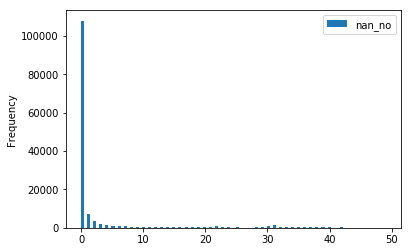

In [46]:
count_nans.plot.hist('nan_no',bins=100);

### Remove rows with more than 50 nans.

In [47]:
print(df.count())
df=df.filter(df.nan_no < 50)
print(df.count())

138882
138882


In [48]:
%%time 
### This is the main cell, where all of the statistics are computed.
STAT=computeStatistics(sqlContext,df)

SELECT * FROM weather
	WHERE measurement = 'SNWD'
SNWD : shape of mdf is  8496
time for SNWD is 21.034867763519287
SELECT * FROM weather
	WHERE measurement = 'TOBS'
TOBS : shape of mdf is  9299
time for TOBS is 24.098997116088867
SELECT * FROM weather
	WHERE measurement = 'SNOW'
SNOW : shape of mdf is  9748
time for SNOW is 24.903972864151
SELECT * FROM weather
	WHERE measurement = 'TOBS_s20'
TOBS_s20 : shape of mdf is  10121
time for TOBS_s20 is 28.332376956939697
SELECT * FROM weather
	WHERE measurement = 'SNWD_s20'
SNWD_s20 : shape of mdf is  10932
time for SNWD_s20 is 27.96428894996643
SELECT * FROM weather
	WHERE measurement = 'TMAX'
TMAX : shape of mdf is  11806
time for TMAX is 30.742621898651123
SELECT * FROM weather
	WHERE measurement = 'TMIN'
TMIN : shape of mdf is  11810
time for TMIN is 29.904306888580322
SELECT * FROM weather
	WHERE measurement = 'SNOW_s20'
SNOW_s20 : shape of mdf is  12155
time for SNOW_s20 is 29.573682069778442
SELECT * FROM weather
	WHERE measurement = 

In [49]:
STAT.keys()

dict_keys(['SNWD', 'TOBS', 'SNOW', 'TOBS_s20', 'SNWD_s20', 'TMAX', 'TMIN', 'SNOW_s20', 'TMAX_s20', 'TMIN_s20', 'PRCP', 'PRCP_s20'])

In [50]:
#STAT['PRCP_s20']

{'Cov': array([[152.54139297, 151.99358305, 151.6271789 , ...,  43.59008177,
          43.62247552,  43.62069043],
        [151.99358305, 151.53111559, 151.26183084, ...,  43.52699552,
          43.56279163,  43.56541584],
        [151.6271789 , 151.26183084, 151.04850899, ...,  43.56854256,
          43.60571094,  43.61080896],
        ...,
        [ 43.59008177,  43.52699552,  43.56854256, ..., 165.83235664,
         165.36886665, 164.78998932],
        [ 43.62247552,  43.56279163,  43.60571094, ..., 165.36886665,
         165.02201903, 164.5457432 ],
        [ 43.62069043,  43.56541584,  43.61080896, ..., 164.78998932,
         164.5457432 , 164.18267445]]),
 'E': array([381981.27807617, 380665.18933105, 379449.90112305, 378288.28643799,
        377060.58642578, 375812.69482422, 374726.16235352, 373652.63305664,
        372573.05078125, 372291.34716797, 371091.51081848, 370141.54455566,
        369156.47302246, 368409.22125244, 367582.43328857, 366795.56811523,
        366087.139770

In [13]:
print("   Name  \t                 Description             \t  Size")
print("-"*80)
print('\n'.join(["%10s\t%40s\t%s"%(s[0],s[1],str(s[2])) for s in STAT_Descriptions]))

   Name  	                 Description             	  Size
--------------------------------------------------------------------------------
SortedVals	                        Sample of values	vector whose length varies between measurements
     UnDef	      sample of number of undefs per row	vector whose length varies between measurements
      mean	                              mean value	()
       std	                                     std	()
    low100	                               bottom 1%	()
   high100	                                  top 1%	()
   low1000	                             bottom 0.1%	()
  high1000	                                top 0.1%	()
         E	                   Sum of values per day	(365,)
        NE	                 count of values per day	(365,)
      Mean	                                    E/NE	(365,)
         O	                   Sum of outer products	(365, 365)
        NO	               counts for outer products	(365, 365)
       Cov	                

In [51]:
## Dump STAT and STST_Descriptions into a pickle file.
from pickle import dump

filename=data_dir+'/STAT_%s.pickle'%state
dump((STAT,STAT_Descriptions),open(filename,'wb'))
!ls -l $data_dir

total 283296
drwxr-xr-x  31 yoavfreund  staff       992 Apr 18 18:12 NY.parquet
-rw-r--r--   1 yoavfreund  staff  66288146 Apr 25 18:59 NY.tgz
-rw-r--r--   1 yoavfreund  staff  51365694 Apr 25 19:11 STAT_NY.pickle
-rw-r--r--   1 yoavfreund  staff  25684524 Apr  1 14:31 WeatherSTAT_NY.pickle
drwxr-xr-x   7 yoavfreund  staff       224 Apr 10 14:38 Weather_Stations.parquet
-rw-r--r--   1 yoavfreund  staff   1605162 Apr 10 14:38 Weather_stations.tgz
drwxr-xr-x  10 yoavfreund  staff       320 Apr 16 14:23 decomp_NY_SNWD.parquet
drwxr-xr-x  10 yoavfreund  staff       320 Apr 16 14:22 decon_NY_SNWD.parquet
drwxr-xr-x  10 yoavfreund  staff       320 Apr 13 12:45 recon_NY_SNWD.parquet
drwxr-xr-x  10 yoavfreund  staff       320 Apr 10 14:22 stations.parquet


In [27]:
X=STAT['TMAX']['Var']
for key in STAT.keys():
    Y=STAT[key]['Var']
    print(key,sum(abs(X-Y)))

TOBS 0.0
TOBS_s20 0.0
TMAX 0.0
TMAX_s20 0.0
TMIN_s20 0.0
TMIN 0.0
SNWD_s20 0.0
SNWD 0.0
SNOW_s20 0.0
SNOW 0.0
PRCP_s20 0.0
PRCP 0.0


In [29]:
!ls -l ../../Data/Weather/STAT*

-rw-r--r--  1 yoavfreund  staff  25684524 Apr  1 14:31 ../../Data/Weather/STAT_NY.pickle


In [30]:
!gzip -f -k ../../Data/Weather/STAT*.pickle
!ls -l ../../Data/Weather/STAT*

-rw-r--r--  1 yoavfreund  staff  14948011 Apr  1 14:31 ../../Data/Weather/STAT_NY.pickle.gz


In [31]:
for state in ['NY']:
    command="aws s3  cp ../../Data/Weather/STAT_%s.pickle.gz s3://mas-dse-open/Weather/by_state/STAT_%s.pickle.gz"%(state,state)
    print(command)
    !$command

aws s3  cp ../../Data/Weather/STAT_NY.pickle.gz s3://mas-dse-open/Weather/by_state/STAT_NY.pickle.gz
upload: ../../Data/Weather/STAT_NY.pickle.gz to s3://mas-dse-open/Weather/by_state/STAT_NY.pickle.gz


In [32]:
!aws s3  ls s3://mas-dse-open/Weather/by_state/ | grep STAT

2018-04-01 14:32:56   14948011 STAT_NY.pickle.gz
2018-03-18 20:33:54   11717259 STAT_RI.pickle.gz


### Summary
* We discussed how to compute the covariance matrix and the expectation matrix when there are `nan` entries.
* The details are all in `computeStatistics`, which is defined in python files you can find in the directory `lib`